In [2]:
import json
import os
import sklearn.metrics
import numpy as np
from pprint import pprint

In [2]:
def evaluate(tasks, berts, domains, runs=10, testing=None):
    for task in tasks:
        for bert in berts:
            for domain in domains:            
                for new_run in range(1, 10):
                    scores=[]
                    for run in range(1, runs+1):
                        DATA_DIR=os.path.join(task, domain)
                        if testing:
                            OUTPUT_DIR=os.path.join("run", bert+"_"+task, domain, str(run))
                        else:
                            OUTPUT_DIR=os.path.join("run", bert+"_"+task, domain, str(new_run), str(run))
                        if os.path.exists(os.path.join(OUTPUT_DIR, "predictions.json") ):
                            if "rrc" in task:
                                ret=!python eval/evaluate-v1.1.py $DATA_DIR/test.json $OUTPUT_DIR/predictions.json
                                score=json.loads(ret[0])
                                scores.append([score["exact_match"], score["f1"] ] )
                            elif "ae" in task:
                                ret=!python eval/evaluate_ae.py --pred_json $OUTPUT_DIR/predictions.json
                                scores.append(float(ret[0])*100 )
                            elif "asc" in task:
                                with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
                                    results=json.load(f)
                                y_true=results['label_ids']
                                y_pred=[np.argmax(logit) for logit in results['logits'] ]
                                p_macro, r_macro, f_macro, _=sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                                f_macro = 2*p_macro*r_macro/(p_macro+r_macro)
                                scores.append([100*sklearn.metrics.accuracy_score(y_true, y_pred), 100*f_macro ] )
                            else:
                                raise Exception("unknown task")
                    scores=np.array(scores)
                    m=scores.mean(axis=0)

                    if len(scores.shape)>1:
                        for iz, score in enumerate(m):
                            print(task, ":", bert, domain, "metric", iz, round(score, 2))
                            pprint(scores)
                            if testing:
                                np.savetxt(task + '_' + domain + '_ftb_test.csv', scores, delimiter=',')
                            else:
                                np.savetxt(str(new_run) + '_' + task + '_' + domain + '_ftb_valid.csv', scores, delimiter=',')
                    else:
                        np.savetxt(task + '_' + domain + '_ftb_test.csv', scores, delimiter=',')
                        print(task, ":", bert, domain, round(m,2))
                        pprint(scores)
                        break


In [ ]:
evaluate(tasks, berts, domains, runs, testing)

/home/tony/Documents/venvs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tony/Documents/venvs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


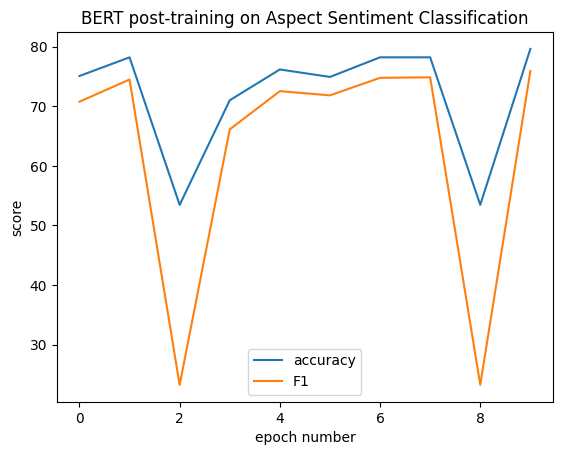

mean accuracy = 71.83385579937304 and mean F1 score = 62.773084521782756


In [4]:
# this works!

import matplotlib.pyplot as plt
import numpy as np

base_dir = "../run/pt_asc/laptop"
scores=[]

for i in range(1, 11):
    OUTPUT_DIR = os.path.join(base_dir, str(i))
    with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
        results=json.load(f)
        y_true=results['label_ids']
        y_pred=[np.argmax(logit) for logit in results['logits'] ]
        p_macro, r_macro, f_macro, _=sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
        f_macro = 2*p_macro*r_macro/(p_macro+r_macro)
        scores.append([100*sklearn.metrics.accuracy_score(y_true, y_pred), 100*f_macro ] )

scores = np.array(scores)

plt.plot(scores[:, 0], label="accuracy")
plt.plot(scores[:, 1], label="F1")
plt.xlabel("epoch number")
plt.ylabel("score")
plt.title("BERT post-training on Aspect Sentiment Classification")
plt.legend()
plt.show()

print(f"mean accuracy = {np.mean(scores[:, 0])} and mean F1 score = {np.mean(scores[:, 1])}")

In [ ]:
import json

# load the ground truth
with open("../data/rrc/laptop/test.json", "r") as f:
    truth = json.load(f)

print(truth["data"][0]["paragraphs"][0]["qas"][0])



{'answers': [{'answer_start': 39, 'text': 'impressed'}], 'id': '30000_0', 'question': 'Do you like your new apple laptop ?'}


In [ ]:

test_file = "../data/rrc/laptop/test.json"
dumped_test_truth = "../data/rrc/laptop/converted_test.json"

# load the ground truth
with open(test_file, "r") as f:
    truth = json.load(f)

truth_dict = {}
for each_data in truth["data"]:
    for each_paragraph in each_data["paragraphs"]:
        for each_qa in each_paragraph["qas"]:
            truth_dict[each_qa["id"]] = [i["text"] for i in each_qa["answers"]]

with open(dumped_test_truth, "w") as f:
    json.dump(truth_dict, f)



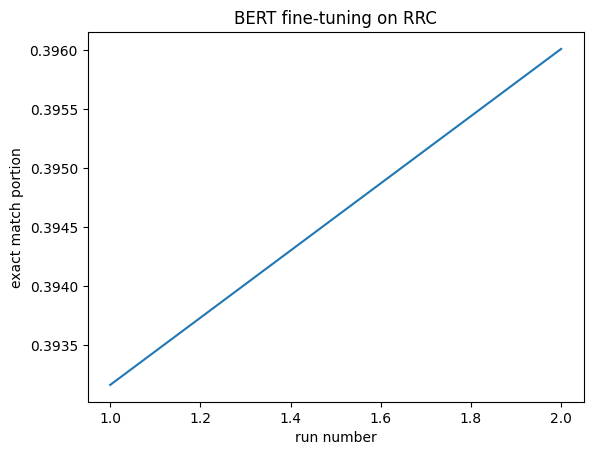

In [5]:
n_runs = 2

import json
import os
import matplotlib.pyplot as plt
import numpy as np

output_dir = "../run/pt_rrc/laptop"
dumped_test_truth = "../data/rrc/laptop/converted_test.json"


with open(dumped_test_truth, "r") as f:
    truth_dict = json.load(f)

exact_matches = []
runs = [i for i in range(1, n_runs+1)]

for i in runs: 
    OUTPUT_DIR = os.path.join(output_dir, str(i))
    with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
        results=json.load(f)
    exact_match = 0
    for each_key in truth_dict.keys():
        if results[each_key] in truth_dict[each_key]:
            exact_match += 1
    exact_matches.append(exact_match/len(results))


plt.plot(runs, exact_matches)
plt.xlabel("run number")
plt.ylabel("exact match portion")
plt.title("BERT fine-tuning on RRC")
plt.show()

# print(f"mean accuracy = {np.mean(scores[:, 0])} and mean F1 score = {np.mean(scores[:, 1])}")